# COVID-19 Data Analysis

Objective: Prepare data visualizations and a corresponding report which highlights CoVID-19 cases and deaths. Separate visualizations for confirmed cases and deaths are included for both the United States and Worldwide. 

- Data on number of cases in each region (US and global) should be displayed. 
- Trend of cases from March till today should be presented
- Deaths from CoVID-19 should be represented visually
- Data on number of cases in each region(US and global) should be displayed. Trend of cases from March till today should be presented

Data Source: Microsoft Bing COVID-19 Tracker https://www.bing.com/covid.
CSV Data - https://github.com/microsoft/Bing-COVID-19-Data

To make sure interactive heatmaps are displayed, you may need to enable Jupyter widgets (using command line or bash: jupyter nbextension enable --py --sys-prefix widgetsnbextension).
Gmaps Docs: https://jupyter-gmaps.readthedocs.io/en/latest/install.html

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import gmaps
from datetime import datetime, timedelta
# Google API Key
from config import gkey
# Configure gmaps
gmaps.configure(api_key=gkey)

In [3]:
# store the url path to the raw csv data on Github, which is updated daily around 3AM PST. This way we can 
data_url = 'https://raw.githubusercontent.com/microsoft/Bing-COVID-19-Data/master/data/Bing-COVID19-Data.csv'


In [4]:
# use pandas to fetch and read in the csv file
covid_df = pd.read_csv(data_url, error_bad_lines=False)
covid_df.head()

,ID,Updated,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude,ISO2,ISO3,Country_Region,AdminRegion1,AdminRegion2
0,338995,01/21/2020,262,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Worldwide,NaN,NaN
1,338996,01/22/2020,313,51.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Worldwide,NaN,NaN
2,338997,01/23/2020,578,265.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Worldwide,NaN,NaN
3,338998,01/24/2020,841,263.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Worldwide,NaN,NaN
4,338999,01/25/2020,1320,479.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Worldwide,NaN,NaN


In [5]:
# output the csv file to use in Tableau
output_file = "./data/Bing-COVID-tracker.csv"
covid_df.to_csv(output_file)

In [6]:
# Inspect the data. How many regions do we have to plot? Whats is the latest date in the dataset?
date_updated = max(covid_df['Updated'])
print('Bing COVID-19 Tracker')
print('Start Date: ', min(covid_df['Updated']))
print('Date Updated: ', date_updated )
print('-----------------------------------')
print('Country Region Counts:')
print(covid_df['Country_Region'].value_counts())
print('-----------------------------------')
print('AdminRegion1 Counts:')
print(covid_df['AdminRegion1'].value_counts())
print('-----------------------------------')
print('AdminRegion2 Counts:')
print(covid_df['AdminRegion2'].value_counts())
# Stats show Region 1 to be at the state/province level
# Region 2 is more granular data for County/municipality

Bing COVID-19 Tracker
Start Date:  01/21/2020
Date Updated:  05/31/2020
-----------------------------------
Country Region Counts:
United States                    179608
India                             11301
United Kingdom                     8624
Russia                             3806
Costa Rica                         3156
                                  ...  
US Virgin Islands                    13
St Marten                            12
St Vincent and the Grenadines        10
Curacao                               3
Vanuatu                               1
Name: Country_Region, Length: 230, dtype: int64
-----------------------------------
AdminRegion1 Counts:
Texas              11143
Georgia            10607
England             7582
Virginia            7341
North Carolina      6264
                   ...  
Luhansk                2
Bonaire                1
Western Sahara         1
Western Visayas        1
Occitanie              1
Name: AdminRegion1, Length: 823, dtype: int64
---

## Create Heatmaps to show Daily Cases and Daily Deaths from COVID-19

Because the data source is updated daily, we can create a subset of the data for the latest/maximum date available for cases and deaths, and make a daily heat map that will update anytime the notebook is run.

In [7]:
date_cases_deaths = covid_df[['Updated', 'Confirmed', 'Deaths', 'Latitude', 'Longitude']]
# filter by the max date field
latest_date_cases_deaths = date_cases_deaths[date_cases_deaths['Updated'] == max(date_cases_deaths['Updated'])]
# rename a few fields
latest_date_cases_deaths = latest_date_cases_deaths.rename(columns={'Updated': 'Date', 'Confirmed': 'Cases'})

latest_date_cases_deaths

,Date,Cases,Deaths,Latitude,Longitude
408,05/31/2020,9394,653.0,28.15509,2.67875
859,05/31/2020,16838,539.0,-35.18115,-65.09386
1824,05/31/2020,9492,139.0,40.29264,44.93948
2030,05/31/2020,7195,103.0,-25.57894,134.35970
2585,05/31/2020,16731,668.0,47.58709,14.14129
...,...,...,...,...,...
253639,05/31/2020,1,0.0,43.05647,-104.47540
253698,05/31/2020,2,0.0,44.52055,-109.58850
253726,05/31/2020,1,0.0,42.13300,-104.96580
254251,05/31/2020,3623,15.0,41.76349,63.15152


In [8]:
# check min and max values of dataset to set granularity for heatmap
print('Min case value:', latest_date_cases_deaths['Cases'].min())
print('Max case value', latest_date_cases_deaths['Cases'].max())

Min case value: 0
Max case value 1778464


In [9]:
# normalize the data to produce a better user experience with the Heat Map formula = (value - min / max - min) * 100
latest_date_cases_deaths['Cases_norm'] = latest_date_cases_deaths['Cases'].apply(lambda x: ((x - min(latest_date_cases_deaths['Cases'])) / (max(latest_date_cases_deaths['Cases']) - min(latest_date_cases_deaths['Cases'])))*100)


## HeatMap of Daily Cases of COVID-19

In [10]:
# set locations and value
locations = latest_date_cases_deaths[['Latitude', 'Longitude']]
value = latest_date_cases_deaths['Cases']

In [11]:
# Plot Heatmap
fig = gmaps.figure(map_type='HYBRID', center=(-3,0), zoom_level=2)
# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=value, 
                                 dissipating=True, max_intensity=100000,
                                 point_radius=40)
# Add layer
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## HeatMap of Daily Deaths of COVID-19

In [12]:
# check min and max values
print('Max Deaths: ', max(latest_date_cases_deaths['Deaths']))

Max Deaths:  97959.0


In [13]:
# set locations and weighted value for heatmap
locations = latest_date_cases_deaths[['Latitude', 'Longitude']]
value = latest_date_cases_deaths['Deaths']

In [14]:
# Plot Heatmap
fig = gmaps.figure(map_type='HYBRID', center=(-3,0), zoom_level=2)
# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=value, 
                                 dissipating=True, max_intensity=1000,
                                 point_radius=40)
# Add layer
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Heatmap Analysis

As of data from 5/28/2019, the data seems to show a concentration of cases in the midwest, which is an interesting contrast to a few weeks previous where the NY area was the most impacted by the pandemic. It would be interesting to follow this trend from cases to deaths over time, which we can get a glimpse using different kinds of visualizations with Matplotlib

In [15]:
# filter out US data to plot cases and deaths at the state level using a time series line plot
usa_df = covid_df[covid_df['Country_Region'] == 'United States']
usa_df.AdminRegion1.value_counts()


Texas                   11143
Georgia                 10607
Virginia                 7341
North Carolina           6264
Missouri                 6097
Kentucky                 6074
Indiana                  6021
Illinois                 5835
Tennessee                5653
Ohio                     5605
Mississippi              5263
Michigan                 5070
Nebraska                 5006
Iowa                     4992
Florida                  4952
Colorado                 4645
Wisconsin                4625
New York                 4575
Arkansas                 4565
Pennsylvania             4540
Alabama                  4531
Kansas                   4453
Louisiana                4424
Minnesota                4333
Oklahoma                 4245
California               3799
South Carolina           3111
Washington               2779
West Virginia            2671
South Dakota             2512
Oregon                   2495
North Dakota             2039
Idaho                    1929
New Mexico

In [16]:
# a little munging with dates to get the two days ago date, formatted the same as our data
today = datetime.now()    
two_days_ago = today - timedelta(days=2)
print(today, '||', two_days_ago)
print(date_updated)
two_days_ago_split = str(two_days_ago).split()[0].split('-')
minus_two_days = f"{two_days_ago_split[1]}/{two_days_ago_split[2]}/{two_days_ago_split[0]}"
print('Date to use: ', minus_two_days)

2020-06-02 16:08:09.419892 || 2020-05-31 16:08:09.419892
05/31/2020
Date to use:  05/31/2020


In [17]:
us_states_totals = usa_df[usa_df['Updated'] == minus_two_days]
us_states_totals = us_states_totals.groupby('AdminRegion1').sum()
us_states_totals

,ID,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude
AdminRegion1,,,,,,,,,
Maine,22248097,2325,43.0,89.0,0.0,1552.0,47.0,45.31528,-69.20395
Maryland,22237218,52778,763.0,2411.0,21.0,3764.0,115.0,38.95252,-76.70122
Michigan,22209943,57397,513.0,5491.0,28.0,0.0,0.0,44.86262,-85.73514
Minnesota,1484221859,24024,630.0,1021.0,13.0,0.0,0.0,3034.99145,-6327.75473
New Hampshire,22552586,4651,106.0,245.0,3.0,0.0,0.0,43.68553,-71.57760
New Mexico,22343150,7689,65.0,356.0,5.0,2853.0,18.0,34.42132,-106.10840
Ohio,22196419,35513,479.0,2155.0,6.0,0.0,0.0,40.41305,-82.71122
Oklahoma,66906735,7688,-34.0,394.0,-2.0,3321.0,-127.0,105.38507,-292.20160
Oregon,22299131,4243,58.0,153.0,0.0,0.0,0.0,43.93881,-120.55860


## Matplotlib - Totals by US State Bar Chart

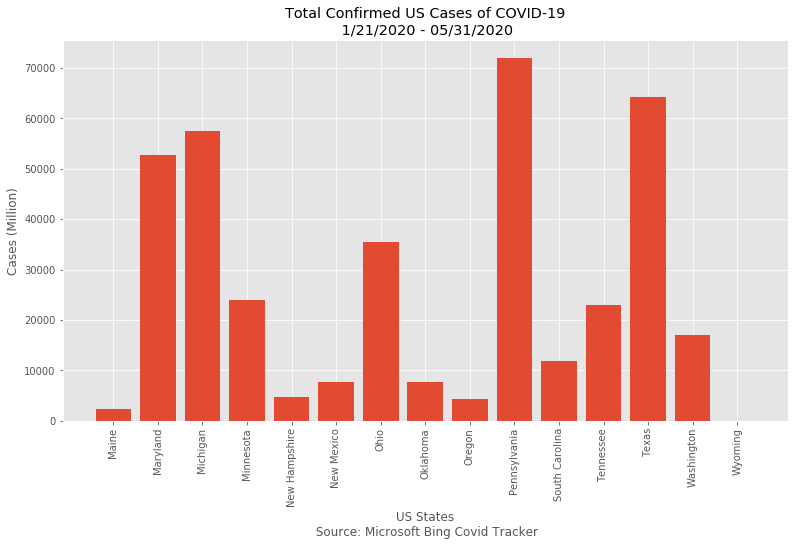

In [18]:
plt.figure(figsize=(13,7))
style.use('ggplot')
plt.bar(us_states_totals.index, us_states_totals['Confirmed'])
plt.title(f'Total Confirmed US Cases of COVID-19\n 1/21/2020 - {minus_two_days}')
plt.ylabel('Cases (Million)')
plt.xlabel('US States\n Source: Microsoft Bing Covid Tracker')
plt.xticks(rotation=90)
plt.savefig('./images/TotalCasesUSA.png')
plt.show()

## Total Cases By Country

From our value counts earlier in the notebook we know that this will be over 200 countries, and a very crowded bar chart! It will be difficult to extract meaning from the data - however this is a good demonstration of the need for client-side filterting of the data, to look at one continent at a time, for example. In our case, this would mean generating a dozen or so bar charts to get the data just for cases and deaths in the USA and World's regions, and that's before we look at different timelines.

Our analysis in Tableau will make this much more easy to view!

In [19]:
country_df = covid_df[covid_df['Updated'] == minus_two_days]
country_df = country_df.groupby('Country_Region').sum()
country_df

,ID,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude
Country_Region,,,,,,,,,
Algeria,22162575,9394,127.0,653.0,7.0,5748.0,199.0,28.15509,2.67875
Argentina,22276435,16838,637.0,539.0,11.0,4788.0,13.0,-35.18115,-65.09386
Armenia,22489417,9492,210.0,139.0,8.0,3386.0,69.0,40.29264,44.93948
Australia,22547837,7195,10.0,103.0,0.0,6614.0,-4.0,-25.57894,134.35970
Austria,22026700,16731,46.0,668.0,0.0,15593.0,73.0,47.58709,14.14129
...,...,...,...,...,...,...,...,...,...
United Arab Emirates,22475574,34557,661.0,264.0,2.0,17932.0,386.0,23.90718,54.33353
United Kingdom,22181377,274762,1936.0,38489.0,0.0,0.0,0.0,53.94384,-2.55056
United States,2628733340,2162886,27776.0,119350.0,734.0,438236.0,8823.0,5349.39366,-12089.78234


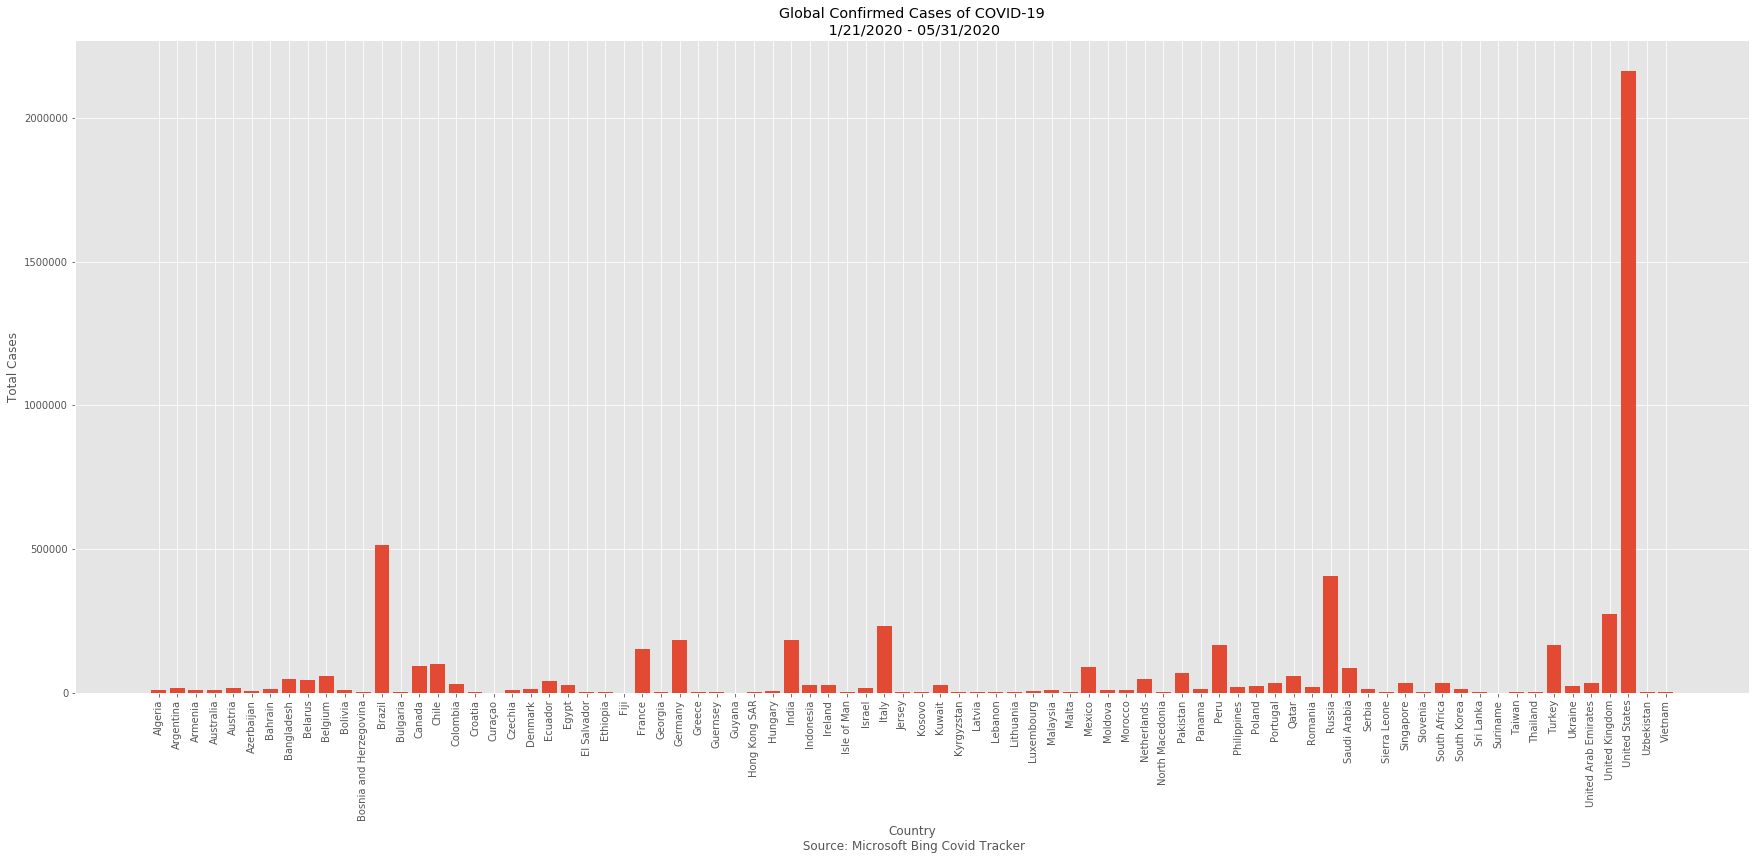

In [20]:
# Plot the total cases for each country around the world
plt.figure(figsize=(30,12))
style.use('ggplot')
plt.bar(country_df.index, country_df['Confirmed'])
plt.title(f'Global Confirmed Cases of COVID-19\n 1/21/2020 - {minus_two_days}')
plt.ylabel('Total Cases')
plt.xlabel('Country\n Source: Microsoft Bing Covid Tracker')
plt.xticks(rotation=90)
plt.savefig(f'./images/TotalCasesWorldwide.png')
plt.show()

In [21]:
# let's do it one more time, showing just countries with over 50k cases?
country_df_over50k = country_df[country_df['Confirmed'] > 50000]
# 80 rows seems more manageable...
country_df_over50k

,ID,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude
Country_Region,,,,,,,,,
Belgium,22009991,58381,195.0,9467.0,14.0,15887.0,118.0,50.64119,4.66057
Brazil,22364339,514849,16409.0,29314.0,480.0,206555.0,5663.0,-10.77680,-53.06805
Canada,22368091,90947,757.0,7295.0,222.0,48879.0,776.0,62.53604,-96.38835
Chile,22201002,99688,4830.0,1054.0,57.0,42727.0,2296.0,-35.23201,-71.21883
France,22512347,151753,257.0,28802.0,31.0,68355.0,87.0,46.62184,2.45194
Germany,22400209,181482,286.0,8500.0,11.0,165226.0,397.0,51.12181,10.40069
India,22422948,182143,8380.0,5164.0,193.0,86984.0,4615.0,22.49312,79.72701
Italy,22333714,233019,355.0,33415.0,75.0,157507.0,1874.0,43.52903,12.16218
Mexico,22328742,90664,3152.0,9930.0,151.0,61871.0,2261.0,23.94062,-102.52510


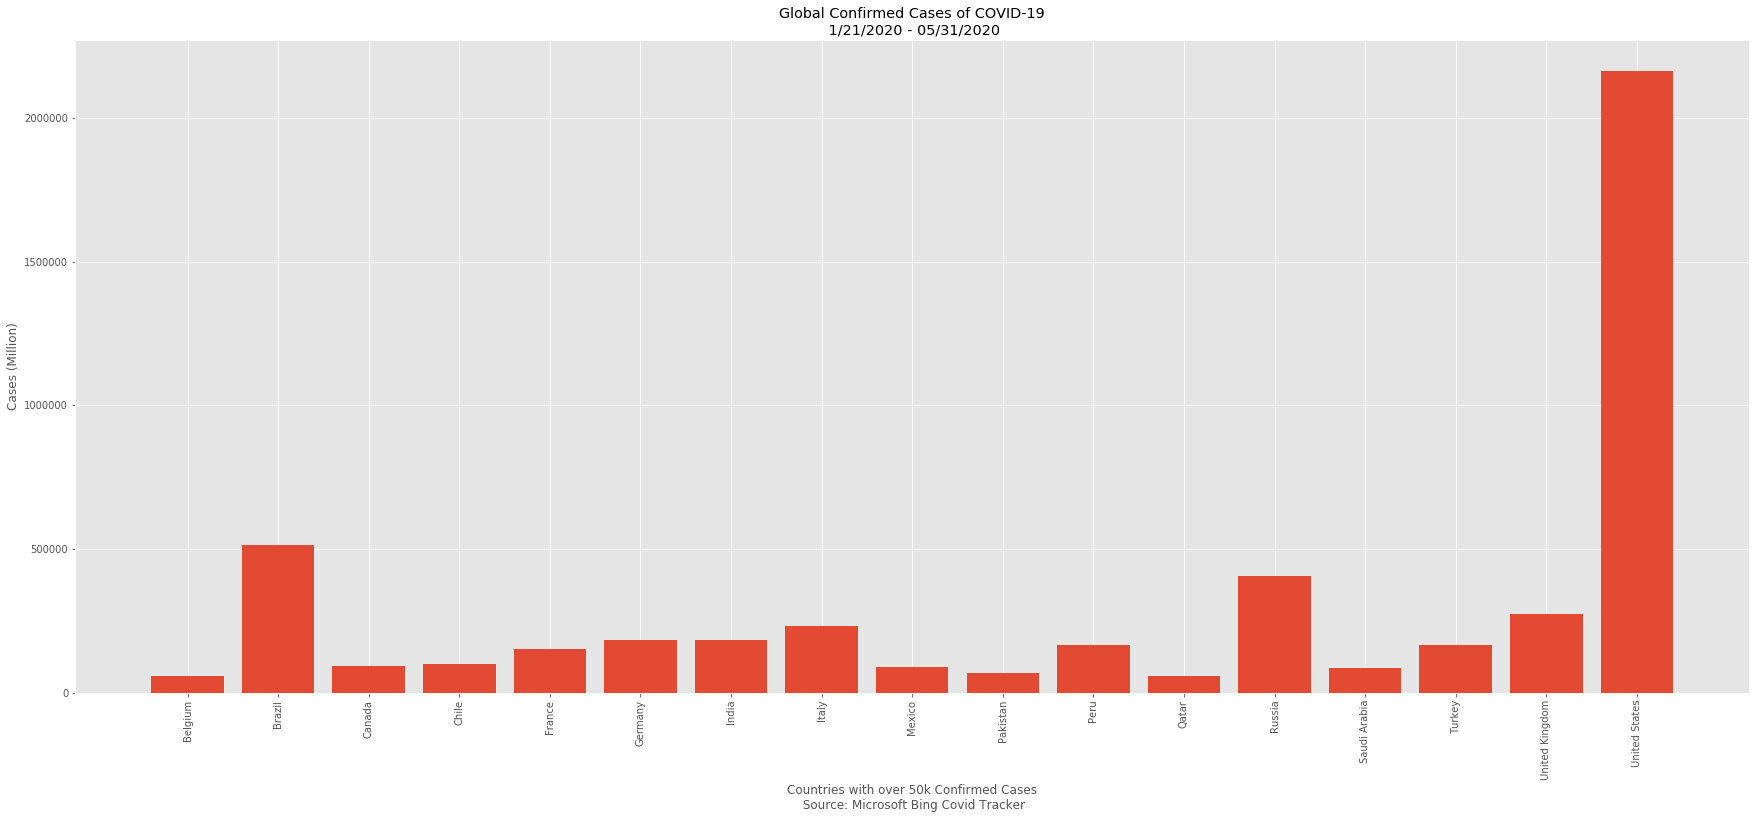

In [22]:
# Plot the total cases for each country around the world
plt.figure(figsize=(30,12))
style.use('ggplot')
plt.bar(country_df_over50k.index, country_df_over50k['Confirmed'])
plt.title(f'Global Confirmed Cases of COVID-19\n 1/21/2020 - {minus_two_days}')
plt.ylabel('Cases (Million)')
plt.xlabel('Countries with over 50k Confirmed Cases\n Source: Microsoft Bing Covid Tracker')
plt.xticks(rotation=90)
plt.savefig(f'./images/TotalCasesWorldwide_over100k.png')
plt.show()

## Bar Chart Analysis

After cutting out a large chunk of the data set, we get a clear picture of the latest stats from 48 hours ago:
- Looking at USA v World Wide, it is clear that the United States makes up 5/6 of the world's cases of COVID-19
- Of the 5 Million or so Cases in the USA, New York (roughly 700k) and New Jersey (roughly 300k) account for around 20% of total USA Cases

We could go on to do make similar charts for deaths...but what might be more intriguing would be to look at other social and economic factors to determine why the USA is such a hotspot for COVID, particularly in the mid-atlantic

In [23]:
# reformat data for timeseries, group by both date and state
us_states_time = usa_df.groupby(['Updated', 'AdminRegion1']).sum()
us_states_time = us_states_time.reset_index()
us_states_time

,Updated,AdminRegion1,ID,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude
0,01/21/2020,Alabama,1859,0,0.0,0.0,0.0,0.0,0.0,32.76650,-86.84031
1,01/21/2020,Alaska,2509,0,0.0,0.0,0.0,0.0,0.0,63.17412,-153.70430
2,01/21/2020,Arizona,5624,0,0.0,0.0,0.0,0.0,0.0,34.29308,-111.66470
3,01/21/2020,Arkansas,5975,0,0.0,0.0,0.0,0.0,0.0,34.89992,-92.43887
4,01/21/2020,California,19715,0,0.0,0.0,0.0,0.0,0.0,37.25510,-119.61750
...,...,...,...,...,...,...,...,...,...,...,...
5312,05/31/2020,South Carolina,22262292,11861,467.0,494.0,7.0,0.0,0.0,33.90385,-80.89377
5313,05/31/2020,Tennessee,22283889,23006,440.0,364.0,0.0,15300.0,107.0,35.84300,-86.34305
5314,05/31/2020,Texas,22299091,64287,1949.0,1672.0,24.0,13353.0,0.0,31.46276,-99.33303
5315,05/31/2020,Washington,722439042,17025,80.0,991.0,6.0,0.0,0.0,1561.52739,-3990.23160


In [24]:
# Make a time series chart for just New York state to inspect the cases v. deaths from March onward
ny_state_time = us_states_time[us_states_time['AdminRegion1'] == 'New York']
ny_state_time = ny_state_time[ny_state_time['Updated'] >= '03/01/2020']
ny_state_time

,Updated,AdminRegion1,ID,Confirmed,ConfirmedChange,Deaths,DeathsChange,Recovered,RecoveredChange,Latitude,Longitude
695,03/01/2020,New York,7154292,1,1.0,0.0,0.0,0.0,0.0,42.93708,-75.61069
746,03/02/2020,New York,7154294,1,0.0,0.0,0.0,0.0,0.0,42.93708,-75.61069
797,03/03/2020,New York,7154307,2,1.0,0.0,0.0,0.0,0.0,42.93708,-75.61069
848,03/04/2020,New York,7154309,11,9.0,0.0,0.0,0.0,0.0,42.93708,-75.61069
899,03/05/2020,New York,7154311,22,11.0,0.0,0.0,0.0,0.0,42.93708,-75.61069
...,...,...,...,...,...,...,...,...,...,...,...
5079,05/26/2020,New York,1229931374,728228,2209.0,47083.0,155.0,0.0,0.0,2681.45275,-4755.19071
5130,05/27/2020,New York,1267277729,731112,2884.0,47240.0,157.0,0.0,0.0,2681.45275,-4755.19071
5181,05/28/2020,New York,1295774207,734423,3311.0,47298.0,58.0,0.0,0.0,2681.45275,-4755.19071
5232,05/29/2020,New York,1331768783,737290,2867.0,45506.0,207.0,0.0,0.0,2681.45275,-4755.19071


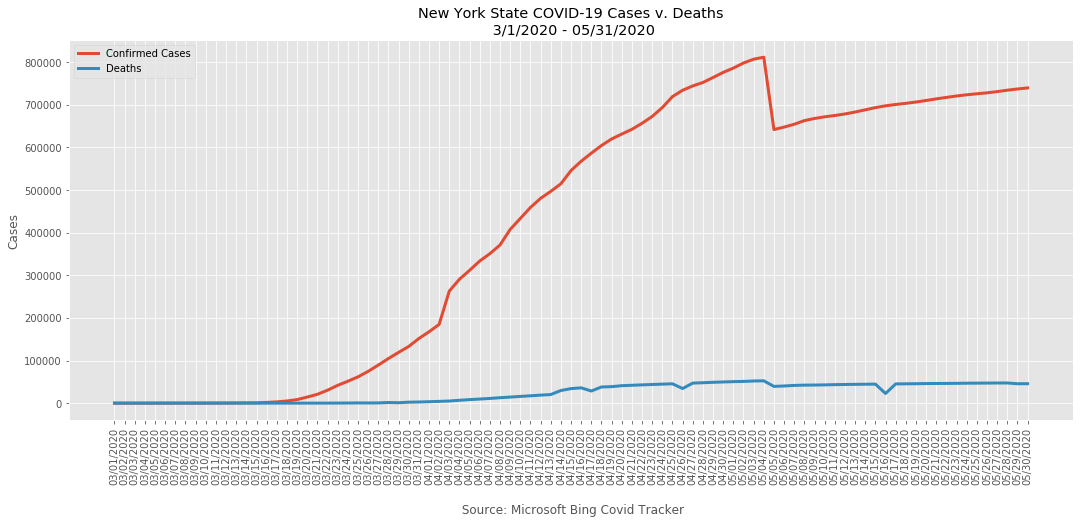

In [25]:
plt.figure(figsize=(18,7))
style.use('ggplot')
plt.plot(ny_state_time['Updated'], ny_state_time['Confirmed'], label='Confirmed Cases', linewidth=3)
plt.plot(ny_state_time['Updated'], ny_state_time['Deaths'], label='Deaths', linewidth=3)
plt.title(f'New York State COVID-19 Cases v. Deaths\n 3/1/2020 - {date_updated}')
plt.ylabel('Cases')
plt.xlabel('\n Source: Microsoft Bing Covid Tracker')
plt.xticks(rotation=90)
plt.savefig('./images/NYTimeline.png')
plt.legend(loc='upper left')
plt.show()

# Analysis

There is a lot more exploration we could do with this approach. Taking a closer look at New York's growing count of confirmed cases over time, we see a spike in cases that drops off at the start of May, but begins to creep back up and does not appear to slow...is there indeed a second, more gradual spike on the way?

Our next move could be to write a function that will generate a similar line chart for each of the 50 states, or approach this from day over day change in cases and deaths at different scopes of granularity for US regions as well as worldwide. Ultimately, one line chart with 50 lines will be cluttered and difficult to read. These plots are rasterized with no possibility for interaction with the data, although some additional annotations or labels would be useful to tell a particular story.  Even the heatmaps have no tooltip functionality to gain more valuable insights. While this more plodding and detailed approach is great for data exploration, pulling the dataset into Tableau will open the doorways for greater possibilities for user interaction, filtering, sorting, and analysis.

The Tableau workbook that continues this study is available here: https://public.tableau.com/profile/stephen.marshall5738#!/vizhome/COVID-19InteractiveDataVisualizationandMapping/COVID19-MicrosoftBingTracker